In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases #参见资料包，或者在文章底部copy
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward #参见资料包
import lr_utils #参见资料包，或者在文章底部copy

np.random.seed(1)

# 神经网络组件
## 初始化参数

In [2]:
def initialize_parameters(n_x,n_h,n_y):
    """
    此函数是为了初始化两层网络参数而使用的函数。
    参数：
        n_x - 输入层节点数量
        n_h - 隐藏层节点数量
        n_y - 输出层节点数量
    
    返回：
        parameters - 包含你的参数的python字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    #使用断言确保我的数据格式是正确的
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters  

def initialize_parameters_deep(layers_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表
    
    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    L = len(layers_dims)
    parameters = {}
    
    for i in range(1,L):
        parameters["W" + str(i)] = np.random.randn(layers_dims[i], layers_dims[i-1]) / np.sqrt(layers_dims[i-1])
        parameters["b" + str(i)] = np.zeros(shape=(layers_dims[i],1))

    return parameters

## 前向传播

In [3]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A, W, b)
    return Z,cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的字典，我们需要存储它以有效地计算后向传递
    """
    Z,linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
        
    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A,cache

def L_model_forward(X,parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION
    
    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出
    
    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    L = len(parameters) // 2
    A = X
    caches = []
    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    
    return AL,caches

## 计算损失

In [4]:
def compute_cost(AL, Y):
    """
    实施等式（4）定义的成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log(1-AL))) / m
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

## 后向传播

In [5]:
def linear_backward(dZ,cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev,W,b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev,dW,db

def linear_activation_backward(dA,cache,activation="relu"):
    """
    实现LINEAR-> ACTIVATION层的后向传播。
    
    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播
    
    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache
    
    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape)
    dAL = - np.divide(Y, AL) + np.divide(1-Y, 1-AL)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        # csdn原文（dA(l+1)有错，但不影响结果 就是输入属于A0还是A1的问题
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_activation_backward(grads["dA" + str(l+1)],current_cache,"relu")
    
    return grads

## 更新参数

In [77]:
def update_parameters(parameters, grads, learning_rate, t):
    """
    使用梯度下降更新参数
    
    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出
    
    返回：
     parameters - 包含更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    if( t < 100):
        print("W2: ",parameters["W2"])
        print("dw:",grads["dW2"])
    
    return parameters

### 采用Adam优化器更新，TODO:存在部分梯度为O的情况

In [83]:
Vgrads_prev = {}
Sgrads_prev = {}
beta = 0.9
beta2 = 0.999
eps = 1e-8

for l in range(2):
    Vgrads_prev["dW" + str(l+1)] = 0
    Vgrads_prev["db" + str(l+1)] = 0
    Sgrads_prev["dW" + str(l+1)] = 0
    Sgrads_prev["db" + str(l+1)] = 0

def update_parameters(parameters, grads, learning_rate, iteration):
    t = iteration + 1
    L = len(parameters) // 2
    for l in range(L):
        Vdw_prev = Vgrads_prev["dW" + str(l+1)]
        Vdb_prev = Vgrads_prev["db" + str(l+1)]
        Sdw_prev = Sgrads_prev["dW" + str(l+1)]
        Sdb_prev = Sgrads_prev["db" + str(l+1)]
        dW = grads["dW" + str(l+1)]
        db = grads["db" + str(l+1)]
        Vdw = beta * Vdw_prev + (1-beta) * dW
        Vdb = beta * Vdb_prev + (1-beta) * db
        Sdw = beta2 * Sdw_prev + (1-beta2) * np.square(dW)
        Sdb = beta2 * Sdb_prev + (1-beta2) * np.square(db)
        Sdw = Sdw / (1 - np.power(beta2, t))
        Sdb = Sdb / (1 - np.power(beta2, t))
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * (Vdw / (np.sqrt(Sdw) + eps))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * (Vdb / (np.sqrt(Sdb) + eps))
        Vgrads_prev["dW" + str(l+1)] = Vdw
        Vgrads_prev["db" + str(l+1)] = Vdb
        Sgrads_prev["dW" + str(l+1)] = Sdw
        Sgrads_prev["db" + str(l+1)] = Sdb
        
    if( t < 100):
        print("W2: ",parameters["W2"])
        print("dw: ",grads["dW2"])
        print("vdw: ",Vdw)
        print("sdw: ",Sdw)
        print("vdw/sqrt(sdw): ",Vdw / (np.sqrt(Sdw) + eps))
    
    return parameters

第 0 次迭代，成本值为： 0.6930497356599891
W2:  [[-0.00959346  0.02520736  0.00038423  0.02709782 -0.00110522  0.01459809
  -0.00396124]]
dw:  [[0.09404696 0.02508094 0.02968109 0.00440414 0.06447493 0.00011402
  0.03960719]]
vdw:  [[9.40469613e-03 2.50809365e-03 2.96810907e-03 4.40414111e-04
  6.44749312e-03 1.14022505e-05 3.96071871e-03]]
sdw:  [[4.42462778e-03 3.14684031e-04 4.40703926e-04 9.70308101e-06
  2.07954815e-03 6.50381770e-09 7.84757015e-04]]
vdw/sqrt(sdw):  [[0.14138598 0.14138592 0.14138593 0.14138554 0.14138597 0.14136847
  0.14138595]]
W2:  [[-0.01006638  0.02515509  0.00033196  0.02704555 -0.00171746  0.01454582
  -0.00478919]]
dw:  [[0.7254501  0.         0.         0.         0.69689348 0.
  0.67389401]]
vdw:  [[8.10092365e-02 2.25728429e-03 2.67129817e-03 3.96372700e-04
  7.54920920e-02 1.02620254e-05 7.09540476e-02]]
sdw:  [[1.65047692e+00 1.04894642e-01 1.46901260e-01 3.23435926e-03
  8.55231323e-01 2.16793851e-06 4.13114774e-01]]
vdw/sqrt(sdw):  [[0.06305649 0.00696963 0.

W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[6.05263020e-01 4.64754818e-04 5.49996604e-04 8.16096240e-05
  1.01493875e+00 2.11286003e-06 5.74683196e-01]]
sdw:  [[1.64285280e+30 1.04375018e+29 1.46173545e+29 3.21833700e+27
  8.52405255e+29 2.15719905e+24 4.11565221e+29]]
vdw/sqrt(sdw):  [[4.72220476e-16 1.43855217e-18 1.43855217e-18 1.43855217e-18
  1.09930139e-15 1.43855217e-18 8.95796094e-16]]
W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[6.18849282e-01 4.18279336e-04 4.94996943e-04 7.34486616e-05
  1.03953643e+00 1.90157403e-06 5.87744446e-01]]
sdw:  [[8.71594785e+31 5.53748468e+30 7.75505268e+30 1.70744802e+29
  4.52232834e+31 1.14447469e+26 2.18350726e+31]]
vdw/sqrt(sdw):  [[6.62868802e-17 1.77750218e-19 1.77750

W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[7.15950023e-01 8.61200060e-05 1.01915481e-04 1.51224281e-05
  1.21533553e+00 3.91517229e-07 6.81092934e-01]]
sdw:  [[4.29787606e+55 2.73056049e+54 3.82405400e+54 8.41950879e+52
  2.22998199e+55 5.64346007e+49 1.07669800e+55]]
vdw/sqrt(sdw):  [[1.09208329e-28 5.21168490e-32 5.21168490e-32 5.21168490e-32
  2.57362648e-28 5.21168490e-32 2.07567532e-28]]
W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[7.18467584e-01 7.75080054e-05 9.17239330e-05 1.36101853e-05
  1.21989353e+00 3.52365507e-07 6.83513210e-01]]
sdw:  [[1.24771633e+57 7.92708974e+55 1.11016106e+56 2.44426747e+54
  6.47386037e+56 1.63835281e+51 3.12576179e+56]]
vdw/sqrt(sdw):  [[2.03399204e-29 8.70541889e-33 8.70541

W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[7.38894341e-01 7.63276284e-06 9.03270602e-06 1.34029144e-06
  1.25687579e+00 3.46999298e-08 7.03150618e-01]]
sdw:  [[5.12438221e+86 3.25566289e+85 4.55944145e+85 1.00386285e+84
  2.65882028e+86 6.72872972e+80 1.28375318e+86]]
vdw/sqrt(sdw):  [[3.26408593e-44 1.33771025e-48 1.33771025e-48 1.33771025e-48
  7.70810942e-44 1.33771025e-48 6.20594034e-44]]
W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[7.39117471e-01 6.86948656e-06 8.12943542e-06 1.20626230e-06
  1.25727977e+00 3.12299368e-08 7.03365125e-01]]
sdw:  [[9.08033101e+87 5.76898746e+86 8.07926418e+86 1.77883042e+85
  4.71139100e+87 1.19232115e+82 2.27479203e+87]]
vdw/sqrt(sdw):  [[7.75644340e-45 2.86005563e-49 2.86005

W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[7.40927882e-01 6.76487048e-07 8.00563145e-07 1.18789201e-07
  1.26055748e+00 3.07543330e-09 7.05105576e-01]]
sdw:  [[6.17234915e+113 3.92146551e+112 5.49187462e+112 1.20915883e+111
  3.20256500e+113 8.10479536e+107 1.54628842e+113]]
vdw/sqrt(sdw):  [[9.43084692e-58 3.41613705e-63 3.41613705e-63 3.41613705e-63
  2.22747931e-57 3.41613705e-63 1.79311812e-57]]
W2:  [[-0.01012668  0.02515191  0.00032878  0.02704237 -0.00182495  0.01454264
  -0.00489932]]
dw:  [[0.74112564 0.         0.         0.         1.26091552 0.
  0.70529569]]
vdw:  [[7.40947658e-01 6.08838343e-07 7.20506831e-07 1.06910281e-07
  1.26059329e+00 2.76788997e-09 7.05124588e-01]]
sdw:  [[7.92122968e+114 5.03257806e+113 7.04794871e+113 1.55176329e+112
  4.10998345e+114 1.04012174e+109 1.98441556e+114]]
vdw/sqrt(sdw):  [[2.63263849e-58 8.582360

第 200 次迭代，成本值为： 0.6778465673620627
第 300 次迭代，成本值为： 0.6778465673620627


D:\tech\Anaconda3\envs\pytorch1.4-cuda10.1\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in true_divide
D:\tech\Anaconda3\envs\pytorch1.4-cuda10.1\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in true_divide


第 400 次迭代，成本值为： 0.6778465673620627


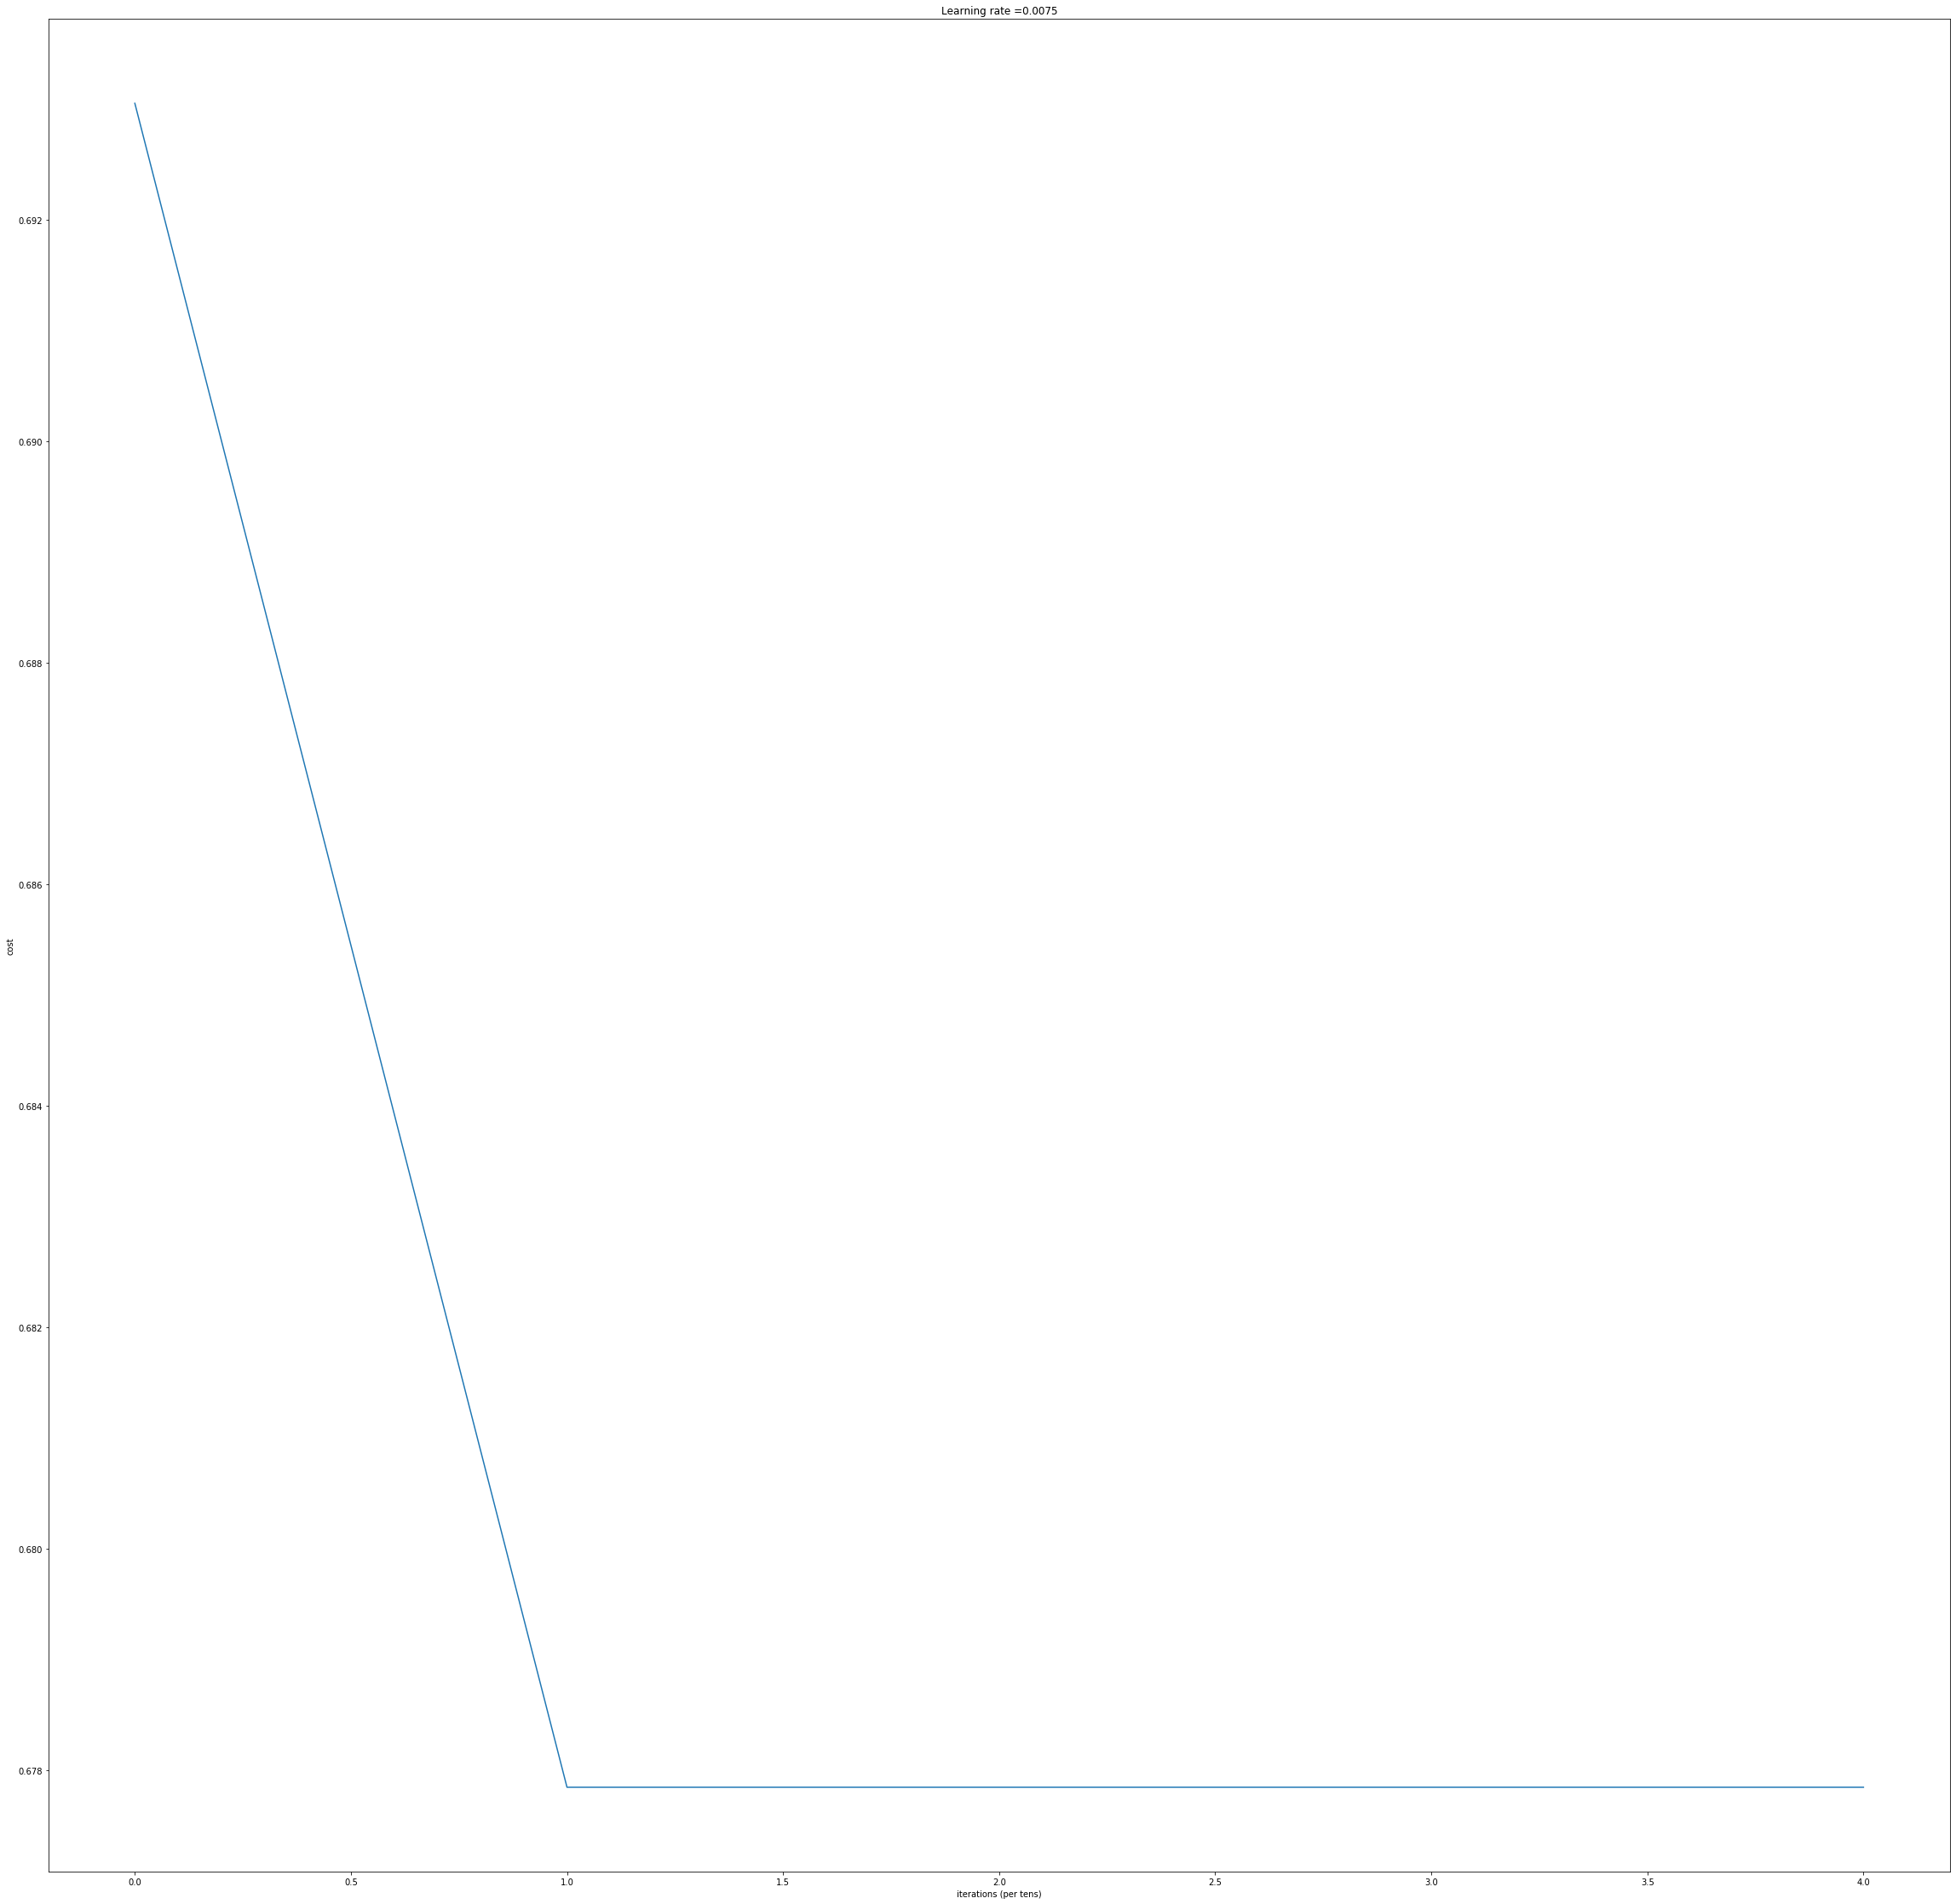

准确度:0.6555023923444976
准确度:0.34


In [84]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)


parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 500, print_cost=True,isPlot=True)

predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集

# 搭建两层神经网络
## 模型

In [74]:
def two_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=3000,print_cost=False,isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_x,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    n_x,n_h,n_y = layers_dims
    grads = {}
    costs = []
    # 初始化参数
    parameters = initialize_parameters(n_x, n_h, n_y)
    t = 0
    
    for i in range(num_iterations):
        # 前向
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # 计算成本
        cost = compute_cost(A2, Y)
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
                
        # 后向
        dA2 = -np.divide(Y, A2) + np.divide(1-Y, 1-A2)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        # 更新
        parameters = update_parameters(parameters, grads, learning_rate, iteration=i)
        
    # 绘图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    return parameters

## 训练

第 0 次迭代，成本值为： 0.6930497356599891
W2:  [[-0.00923842  0.02607965  0.00122201  0.02812518 -0.00052839  0.0156575
  -0.0031979 ]]
dw: [[0.09404696 0.02508094 0.02968109 0.00440414 0.06447493 0.00011402
  0.03960719]]
W2:  [[-0.00996163  0.02592067  0.00100249  0.02809494 -0.00100987  0.01565666
  -0.00349844]]
dw: [[0.09642829 0.02119729 0.02927013 0.00403305 0.06419831 0.00011121
  0.04007211]]
W2:  [[-0.01070363  0.02578875  0.00078571  0.02806723 -0.00149053  0.01565585
  -0.00380304]]
dw: [[0.09893289 0.01758854 0.02890347 0.00369462 0.06408689 0.00010841
  0.04061272]]
W2:  [[-0.01146556  0.02567907  0.00057137  0.02804168 -0.00197153  0.01565506
  -0.00411247]]
dw: [[0.10159173 0.01462483 0.0285791  0.00340619 0.0641333  0.00010564
  0.04125843]]
W2:  [[-0.01224954  0.02558654  0.00035917  0.0280179  -0.00245399  0.01565429
  -0.00442727]]
dw: [[1.04529511e-01 1.23368116e-02 2.82928503e-02 3.17104065e-03
  6.43292388e-02 1.02898473e-04 4.19731484e-02]]
W2:  [[-0.01305697  0.0255056 

W2:  [[-0.06858211  0.02455851 -0.00725388  0.02785005 -0.02910905  0.01564051
  -0.02387025]]
dw: [[ 2.02501407e-01  1.16243322e-03  1.63214213e-02 -3.60476382e-04
   9.10401200e-02 -1.07588316e-05  6.10697779e-02]]
W2:  [[-0.07005919  0.02454998 -0.00736929  0.02785288 -0.02977483  0.01564061
  -0.02430902]]
dw: [[ 1.96944324e-01  1.13678069e-03  1.53869900e-02 -3.77211303e-04
   8.87697288e-02 -1.33790666e-05  5.85022128e-02]]
W2:  [[-0.07149163  0.02454164 -0.00747738  0.02785584 -0.03042232  0.01564073
  -0.02472753]]
dw: [[ 1.90991627e-01  1.11158982e-03  1.44119318e-02 -3.93814281e-04
   8.63328095e-02 -1.59656277e-05  5.58015613e-02]]
W2:  [[-0.07287689  0.02453349 -0.00757805  0.02785891 -0.03105047  0.01564087
  -0.02512496]]
dw: [[ 1.84700805e-01  1.08687592e-03  1.34234603e-02 -4.10259445e-04
   8.37528987e-02 -1.85168861e-05  5.29908945e-02]]
W2:  [[-0.07421289  0.02452552 -0.00767127  0.02786211 -0.03165838  0.01564103
  -0.02550067]]
dw: [[ 1.78133395e-01  1.06265099e-03

W2:  [[-0.09662749  0.02430262 -0.00765683  0.02805793 -0.04308444  0.01565931
  -0.02778038]]
dw: [[ 3.06310366e-02  6.51833683e-04 -4.76608381e-03 -8.40366527e-04
   2.00726978e-02 -9.67316568e-05 -1.13988792e-02]]
W2:  [[-0.09685406  0.02429775 -0.00762089  0.02806429 -0.04323377  0.01566005
  -0.02769323]]
dw: [[ 3.02102033e-02  6.50251953e-04 -4.79252227e-03 -8.47606948e-04
   1.99106909e-02 -9.83956327e-05 -1.16210162e-02]]
W2:  [[-0.09707799  0.02429288 -0.0075848   0.0280707  -0.0433821   0.0156608
  -0.02760459]]
dw: [[ 0.02985725  0.00064869 -0.00481246 -0.00085479  0.01977745 -0.00010006
  -0.01181772]]
W2:  [[-0.09729974  0.02428803 -0.0075486   0.02807717 -0.04352963  0.01566156
  -0.02751466]]
dw: [[ 0.02956688  0.00064715 -0.00482645 -0.00086192  0.01967077 -0.00010171
  -0.0119911 ]]
W2:  [[-0.09751975  0.02428318 -0.00751234  0.02808368 -0.04367655  0.01566234
  -0.02742359]]
dw: [[ 0.02933417  0.00064563 -0.00483501 -0.00086901  0.01958858 -0.00010337
  -0.01214307]]


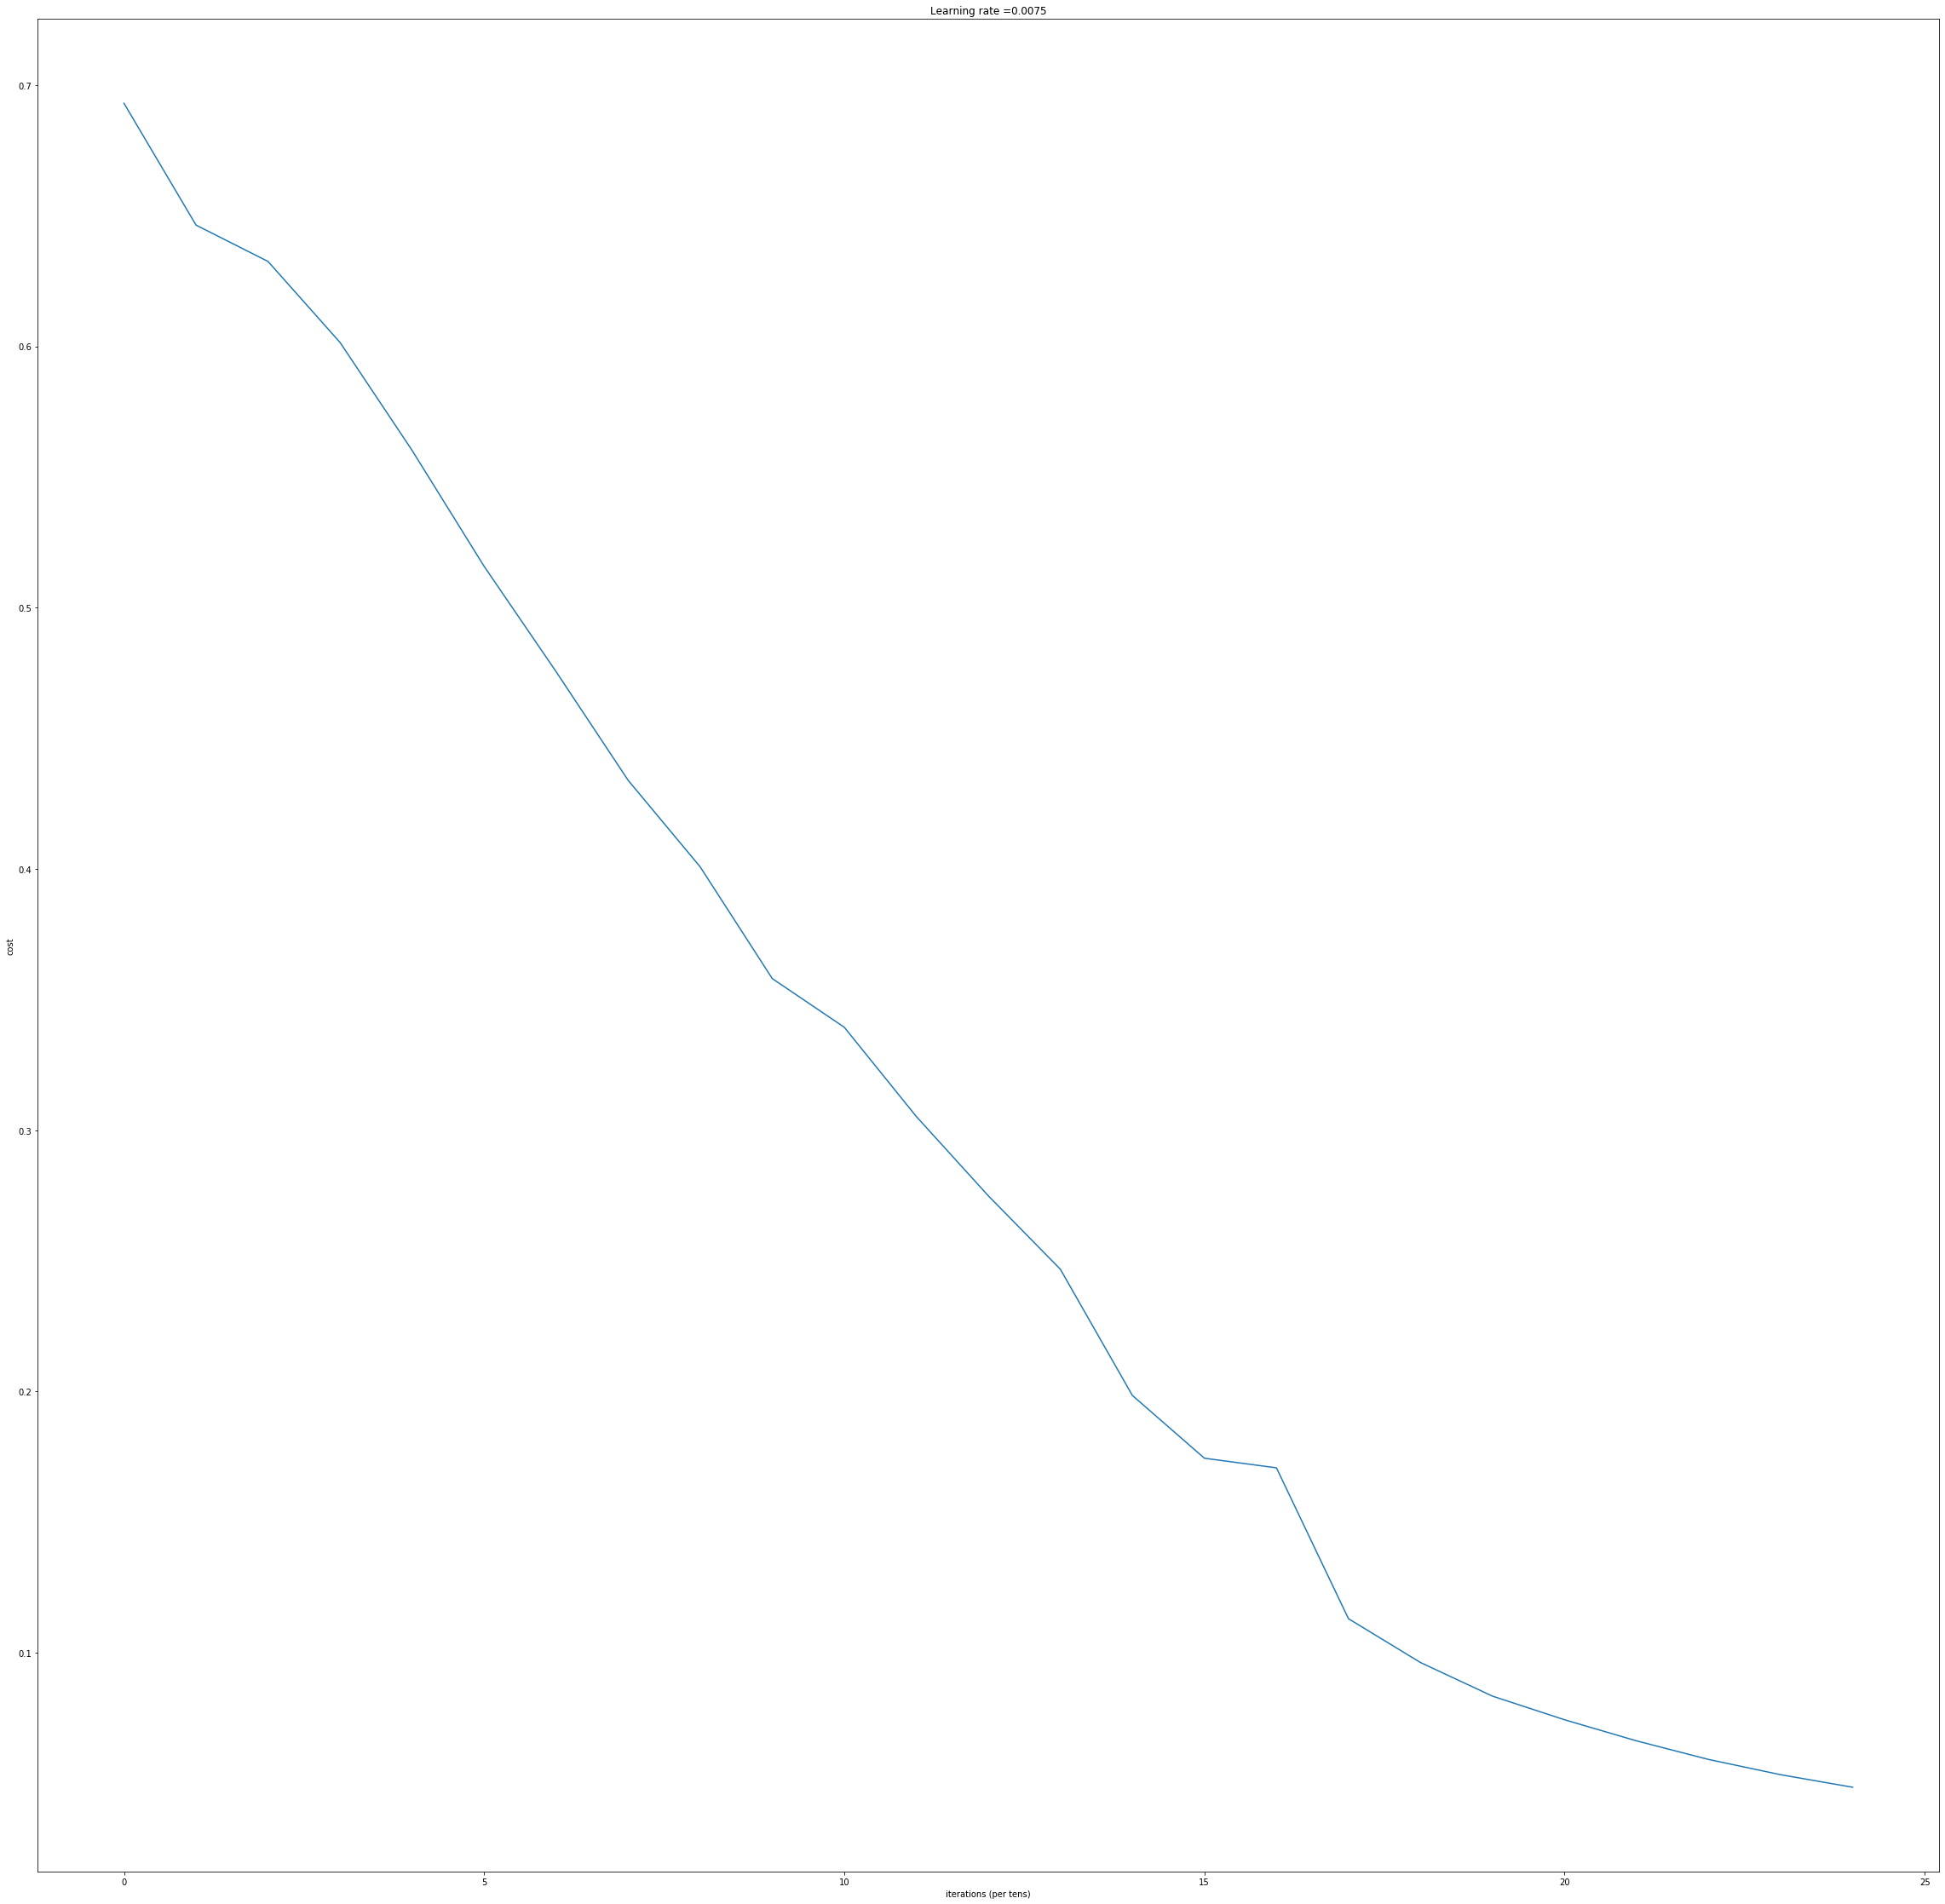

In [78]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True,isPlot=True)

## 预测

In [9]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层
    
    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数
    
    返回：
     p - 给定数据集X的预测
    """
    m = X.shape[1]
    p = np.zeros((1,m))

    probas, cache1 = L_model_forward(X, parameters)
    
    for i in range(0,probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("准确度:" + str(float(np.sum(p == y) / m)))
    return p

In [10]:
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集

准确度:1.0
准确度:0.72


# 搭建多层神经网络
## 模型

In [11]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False, isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。
    
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    
    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    grads = {}
    costs = []
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(num_iterations):
        # 前向
        AL, caches = L_model_forward(X, parameters)
        
        # 计算成本
        if i % 100 == 0:
            cost = compute_cost(AL, Y)
            costs.append(cost)
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
        
        # 后向
        grads = L_model_backward(AL, Y, caches)
        
        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
    
    # 绘图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

## 训练

第 0 次迭代，成本值为： 0.715731513413713
第 100 次迭代，成本值为： 0.6747377593469114
第 200 次迭代，成本值为： 0.6603365433622128
第 300 次迭代，成本值为： 0.6462887802148751
第 400 次迭代，成本值为： 0.6298131216927773
第 500 次迭代，成本值为： 0.6060056229265339
第 600 次迭代，成本值为： 0.5690041263975134
第 700 次迭代，成本值为： 0.519796535043806
第 800 次迭代，成本值为： 0.46415716786282285
第 900 次迭代，成本值为： 0.40842030048298916
第 1000 次迭代，成本值为： 0.37315499216069037
第 1100 次迭代，成本值为： 0.3057237457304712
第 1200 次迭代，成本值为： 0.2681015284774084
第 1300 次迭代，成本值为： 0.23872474827672593
第 1400 次迭代，成本值为： 0.20632263257914712
第 1500 次迭代，成本值为： 0.17943886927493546
第 1600 次迭代，成本值为： 0.15798735818801213
第 1700 次迭代，成本值为： 0.1424041301227393
第 1800 次迭代，成本值为： 0.12865165997885838
第 1900 次迭代，成本值为： 0.11244314998155497
第 2000 次迭代，成本值为： 0.08505631034966696
第 2100 次迭代，成本值为： 0.05758391198605791
第 2200 次迭代，成本值为： 0.0445675345469387
第 2300 次迭代，成本值为： 0.03808275166597669
第 2400 次迭代，成本值为： 0.034410749018403054


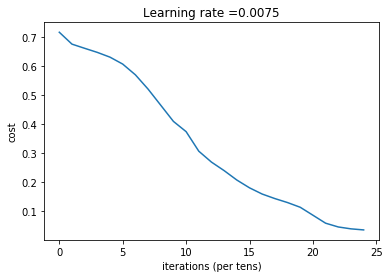

In [12]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

layers_dims = [12288, 20, 7, 5, 1] 
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)

## 预测

In [13]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确度:0.9952153110047847
准确度:0.78


## 显示被错误标记的图片

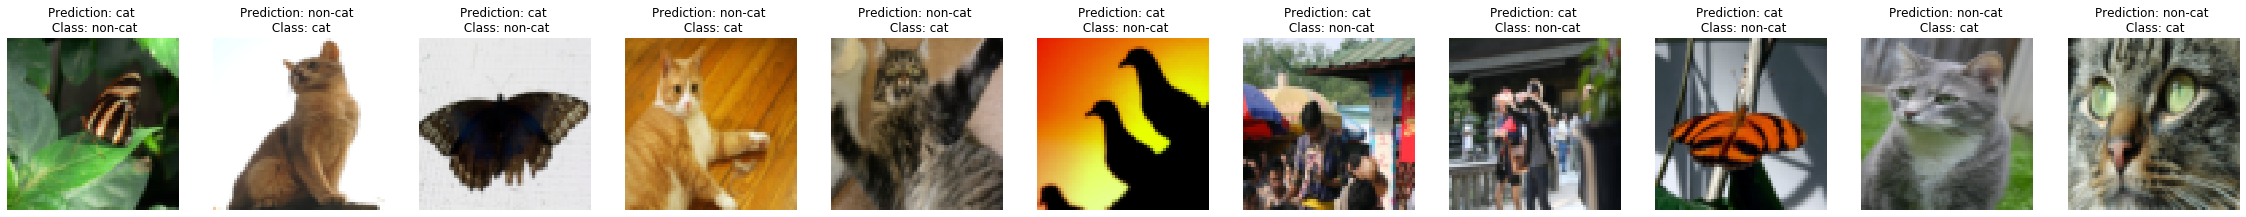

In [14]:
def print_mislabeled_images(classes, X, y, p):
    """
	绘制预测和实际不同的图像。
	    X - 数据集
	    y - 实际的标签
	    p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_images(classes, test_x, test_y, pred_test)

## 预测自己的图片

In [15]:
import imageio
from scipy import misc
from skimage.transform import resize

## START CODE HERE ##
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "E:/pics/sab.jpg"
num_px = 64
#image = np.array(ndimage.imread(fname, flatten=False))
image = np.array(imageio.imread(fname))
#my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = resize(image, output_shape=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

#plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

准确度:1.0
y = 1.0, your L-layer model predicts a "cat" picture.
